In [58]:
%pylab inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import os
import glob
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import fitsne
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from skimage.color import rgb2gray

from pywsi.io import WSIReader
from pywsi.io.operations import read_as_rgb

from pywsi.segmentation import poisson_deconvolve, perform_binary_cut, max_clustering
from pywsi.segmentation import collapse_labels, collapse_small_area, laplace_of_gaussian
from pywsi.segmentation import gmm_thresholding, label_nuclei, extract_features, summarize_region_properties

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization
from pywsi.normalization import VahadaneNormalization
from pywsi.normalization import XuNormalization

from sklearn.decomposition import PCA, FastICA
from skimage.color import rgb2gray
from skimage.io import imread
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
import umap
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=2)

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from tpot import TPOTClassifier
import pickle
from multiprocessing import Pool
from sklearn.metrics import accuracy_score
import xgboost as xgb
from catboost import Pool, CatBoost
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor
from sklearn.grid_search import GridSearchCV


scaler = StandardScaler()

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
normal_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/'
tumor_patches_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/tumor_patches_test/level_0/'
segmented_tsv_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test_segmented/level_0/'

In [ ]:
np.random.seed(42)
list_of_tumor_files = list(glob.glob('{}*.png'.format(tumor_patches_dir)))
list_of_normal_files = list(glob.glob('{}*.png'.format(normal_patches_dir)))

#list_of_tumor_files = list(np.random.choice(list_of_tumor_files, 20000))
#list_of_normal_files = list(np.random.choice(list_of_normal_files, 20000))

In [ ]:
def draw_nuclei(patch, local_max_search_radius=3, min_radius=5, max_radius=15, min_nucleus_area=100):
    patch = read_as_rgb(patch)
    label_nuclei(patch,
                 local_max_search_radius=local_max_search_radius, 
                 min_radius=min_radius,
                 max_radius=max_radius, 
                 min_nucleus_area=min_nucleus_area)
    

In [ ]:
interact(draw_nuclei, patch=list_of_tumor_files+list_of_normal_files)


In [ ]:
patch = read_as_rgb(list_of_tumor_files[0])

In [ ]:
region_properties, fg_mask = label_nuclei(patch)

In [ ]:
features_df = []
labels = []
def process_sample(sample):
    patch = read_as_rgb(sample)
    region_properties, _ = label_nuclei(patch, draw=False) 
    summary = summarize_region_properties(region_properties, 
                                          patch)
    return summary
#for sample in tqdm_notebook(list_of_normal_files):

with tqdm_notebook(total=len(list_of_tumor_files)) as pbar:
    with Pool(processes=32) as p:
        for i, summary in enumerate(p.imap_unordered(process_sample, list_of_tumor_files)):
            pbar.update()
            if summary is None:
                print('Nothing found for {}'.format(sample))
                continue
            else:
                labels.append('tumor')
    features_df.append(summary)
    
pickle.dump(features_df, open('normal.pickle', 'wb'))

In [ ]:
with tqdm_notebook(total=len(list_of_normal_files)) as pbar:
    with Pool(processes=32) as p:
        for i, summary in enumerate(p.imap_unordered(process_sample, list_of_tumor_files)):
            pbar.update()
            if summary is None:
                print('Nothing found for {}'.format(sample))
                continue
            else:
                labels.append('normal')
    features_df.append(summary)
pickle.dump(features_df, open('tumor.pickle', 'wb'))

In [ ]:
#tfile = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test/level_0/tumor_048_33856_186816_256.png'
y = np.array([1  if label=='normal' else 0 for label in labels])

In [ ]:
f = pd.DataFrame(features_df)
X = f.values

In [ ]:
X_scaled = scaler.fit(X).transform(X)

In [ ]:
X_scaled.shape

# PCA

We start of with doing PCA/tSNE on the features.


# UMAP

In [ ]:

embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_scaled)
fig = plt.figure(figsize=(10, 10))

for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(embedding[y == i, 0], embedding[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
fig.tight_layout()
plt.title('UMAP')

In [ ]:
Y = fitsne.FItSNE(X_scaled.copy(order='C'))# max_iter=500)

In [ ]:
std_clf = make_pipeline(StandardScaler(), PCA(n_components=2))
std_clf.fit(X)



In [ ]:
colors = ['navy', 'darkorange']
lw = 0.2
label_matrix = ['normal', 'tumor']

fig = plt.figure(figsize=(10, 10))
for color, i, target_name in zip(colors, [0, 1], label_matrix):
    plt.scatter(Y[y == i, 0], Y[y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)

fig.tight_layout()
plt.title('FIt-SNE')

# Random Forest

In [ ]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=40)
print(clf.feature_importances_)

# LASSO

In [ ]:
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)

In [ ]:
y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

In [ ]:
r2_score_lasso

In [ ]:
alpha = 0.001
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
r2_score_enet

In [ ]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)


In [ ]:
print(pipeline_optimizer.score(X_test, y_test))


In [ ]:
df = pd.DataFrame()
for f in list_of_normal_files:
    uid = f.replace('.png', '.tsv').replace(os.path.dirname(f), '').replace('/', '')
    temp_df = pd.read_table(os.path.join(segmented_tsv_dir, uid))
    df = pd.concat([df, temp_df])
    break


In [ ]:
segmented_tsv_dir

In [ ]:
df

# Load df from files

In [4]:
import pandas as pd
normal_segmented_tsv_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/normal_patches_test_segmented/level_0/'
tumor_segmented_tsv_dir = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16_patches/tumor_patches_test_segmented/level_0/'

In [7]:
df = pd.DataFrame()
y = []

def load_df(path):
    temp_df = pd.read_table(path)
    if len(temp_df.index):
        return temp_df
    return None
normal_segmented_tsv = glob.glob(normal_segmented_tsv_dir+'/*.tsv')
tumor_segmented_tsv = glob.glob(tumor_segmented_tsv_dir+'/*.tsv')
np.random.seed(42)
normal_segmented_tsv_subsampled = np.random.choice(normal_segmented_tsv, 10000)
tumor_segmented_tsv_subsampled = np.random.choice(tumor_segmented_tsv, 10000)

with tqdm_notebook(total=len(normal_segmented_tsv_subsampled)) as pbar:
    with Pool(processes=32) as p:
        for i, temp_df in enumerate(p.imap_unordered(load_df, normal_segmented_tsv_subsampled)):
            if temp_df is not None:
                df = pd.concat((df, temp_df))
                y.append(0)
            pbar.update()

    

In [8]:
with tqdm_notebook(total=len(tumor_segmented_tsv_subsampled)) as pbar:
    with Pool(processes=32) as p:
        for i, temp_df in enumerate(p.imap_unordered(load_df, tumor_segmented_tsv_subsampled)):
            if temp_df is not None:
                df = pd.concat((df, temp_df))
                y.append(1)
            pbar.update()


In [9]:
y = np.array(y)


In [10]:
#label = [0 for x in range(len(glob.glob(normal_segmented_tsv_dir+'/*.tsv')))]
#label += [1 for x in range(len(df.index)-len(label))]
label =y 

In [11]:
len(label)

19991

In [13]:
df.head()

,area,bbox_area,compactness,convex_area,eccentricity,equivalent_diameter,extent,fractal_dimension,inertia_tensor_eigvals_1,inertia_tensor_eigvals_2,...,moments_hu_6,moments_hu_7,nuclei,nuclei_intensity_over_entire_image,orientation,perimeter,solidity,texture,total_nuclei_area,total_nuclei_area_ratio
0,232.333333,560.761905,44.638176,375.904762,0.886223,16.236977,0.415209,0.817727,61.214019,11.609004,...,0.000682,3.902244e-06,21,0.672365,0.227135,95.964815,0.627106,0.090174,4879.0,0.074448
0,189.808989,346.280899,29.611280,251.471910,0.652236,15.313492,0.555221,0.801800,24.894152,13.265463,...,0.000021,2.194104e-08,89,0.516681,-0.018495,72.680816,0.754827,0.008617,16893.0,0.257767
0,276.888889,650.055556,40.273945,433.555556,0.763144,17.279407,0.443033,0.754102,53.680123,17.626986,...,0.000969,-1.249436e-05,36,0.318954,0.267160,96.357512,0.650674,0.019006,9968.0,0.152100
0,223.385965,437.210526,29.231257,292.964912,0.736590,16.314875,0.524369,0.754721,36.435902,13.104881,...,0.000532,-3.753196e-06,57,0.491332,0.325601,78.210713,0.768243,0.020958,12733.0,0.194290
0,222.647059,477.129412,32.963650,326.094118,0.746103,15.650702,0.494120,0.855427,38.151031,13.725385,...,0.000085,1.246536e-07,85,0.748307,0.232896,82.288560,0.702751,0.074568,18925.0,0.288773


In [14]:
df_with_label = df.copy()#.drop(columns=['0'])

In [15]:
df_with_label['label'] = np.nan

In [16]:
df_with_label['label'] = label

In [17]:
df_with_label.head()

,area,bbox_area,compactness,convex_area,eccentricity,equivalent_diameter,extent,fractal_dimension,inertia_tensor_eigvals_1,inertia_tensor_eigvals_2,...,moments_hu_7,nuclei,nuclei_intensity_over_entire_image,orientation,perimeter,solidity,texture,total_nuclei_area,total_nuclei_area_ratio,label
0,232.333333,560.761905,44.638176,375.904762,0.886223,16.236977,0.415209,0.817727,61.214019,11.609004,...,3.902244e-06,21,0.672365,0.227135,95.964815,0.627106,0.090174,4879.0,0.074448,0
0,189.808989,346.280899,29.611280,251.471910,0.652236,15.313492,0.555221,0.801800,24.894152,13.265463,...,2.194104e-08,89,0.516681,-0.018495,72.680816,0.754827,0.008617,16893.0,0.257767,0
0,276.888889,650.055556,40.273945,433.555556,0.763144,17.279407,0.443033,0.754102,53.680123,17.626986,...,-1.249436e-05,36,0.318954,0.267160,96.357512,0.650674,0.019006,9968.0,0.152100,0
0,223.385965,437.210526,29.231257,292.964912,0.736590,16.314875,0.524369,0.754721,36.435902,13.104881,...,-3.753196e-06,57,0.491332,0.325601,78.210713,0.768243,0.020958,12733.0,0.194290,0
0,222.647059,477.129412,32.963650,326.094118,0.746103,15.650702,0.494120,0.855427,38.151031,13.725385,...,1.246536e-07,85,0.748307,0.232896,82.288560,0.702751,0.074568,18925.0,0.288773,0


In [18]:

df_with_label = df_with_label.dropna()
label = df_with_label['label']
df_with_label = df_with_label.drop(columns=['label'])
df_with_label.to_csv('normal_tumor_segmented_df.tsv', sep='\t', index=False, header=True)

In [78]:
matrix = df_with_label.as_matrix()
matrix.shape

(19991, 46)

In [20]:
X_scaled = scaler.fit(matrix).transform(matrix)


In [21]:
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, label,
                                                    test_size=0.30,
                                                    random_state=RANDOM_STATE)


In [22]:
lasso = linear_model.Lasso(alpha = 0.1)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [23]:
y_pred_lasso = lasso.predict(X_test)
r2_score_lasso = r2_score(y_test, y_pred_lasso)

In [24]:
r2_score_lasso

0.026751420515728097

In [25]:
alpha = 0.001
enet = ElasticNet(alpha=alpha, l1_ratio=0.7)

y_pred_enet = enet.fit(X_train, y_train).predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
r2_score_enet

/home/saket/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.2386861048913742

In [53]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)


Optimization Progress:  34%|███▍      | 41/120 [26:10<22:38, 17.20s/pipeline]

Generation 1 - Current best internal CV score: 0.7829624641293058


Optimization Progress:  52%|█████▏    | 62/120 [47:33<2:18:37, 143.41s/pipeline]

Generation 2 - Current best internal CV score: 0.7847490462360064


Optimization Progress:  69%|██████▉   | 83/120 [1:14:32<22:58, 37.26s/pipeline]

Generation 3 - Current best internal CV score: 0.7852494547092663


Optimization Progress:  86%|████████▌ | 103/120 [1:40:20<17:32, 61.94s/pipeline]

Generation 4 - Current best internal CV score: 0.7852494547092663


Generation 5 - Current best internal CV score: 0.7852494547092663

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=False, criterion=entropy, max_features=0.4, min_samples_leaf=12, min_samples_split=3, n_estimators=100)


TPOTClassifier(config_dict={'sklearn.ensemble.GradientBoostingClassifier': {'subsample': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]), 'max_depth': range(1, 11), 'min_samples_split': range(2, 21), 'n_estimators': [100], 'lear... 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=5, max_eval_time_mins=5,
        max_time_mins=None, memory=None, mutation_rate=0.9, n_jobs=1,
        offspring_size=20, periodic_checkpoint_folder=None,
        population_size=20, random_state=42, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

In [56]:
print(pipeline_optimizer.score(X_test, y_test))


0.784594864954985


In [57]:
pipeline_optimizer.export('tpot_exported_pipeline_10ksamples.py')


True

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
num_round = 2
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

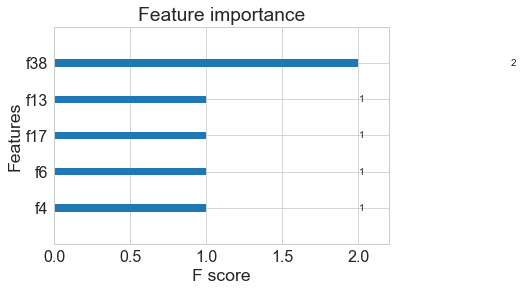

In [30]:
xgb.plot_importance(bst)


In [52]:
df.columns[4]

'eccentricity'

In [48]:
accuracy_score(y_test, [round(x) for x in preds])

0.7152384128042681

In [42]:
model = CatBoostClassifier(iterations=2, depth=2, learning_rate=1, 
                           loss_function='Logloss', logging_level='Verbose')
#train the model
model.fit(X_train, y_train, cat_features=[0,1])
# make the prediction using the resulting model
preds_class = model.predict(X_test)
preds_proba = model.predict_proba(X_test)
print("class = ", preds_class)
print("proba = ", preds_proba)

CatboostError: Invalid type for cat_feature[0,0]=-0.2701392385365741 : cat_features must be integer or string, real number values and NaN values should be converted to string.

IndexError: list index out of range

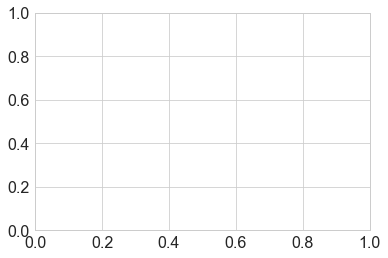

In [34]:
xgb.plot_tree(bst, num_trees=2)


In [55]:
xgb_model = xgb.XGBClassifier()
optimization_dict = {'max_depth': [2,4,6],
                     'n_estimators': [50,100,200]}

model = GridSearchCV(xgb_model, optimization_dict, 
                     scoring='accuracy', verbose=1)

model.fit(X_train, y_train)
print(model.best_score_)
print(model.best_params_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  1.8min finished


0.7816050882584149
{'max_depth': 6, 'n_estimators': 200}


# Test on test dataset

In [63]:
test_tumor_segmented_tsv_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/test_tumor_level0_segmented/level_0/'
test_normal_segmented_tsv_dir = '/Z/personal-folders/interns/saket/histopath_data/baidu_images/test_normal_level0_segmented/level_0/'

In [65]:
from multiprocessing import Pool

In [66]:
test_df = pd.DataFrame()
test_y = []


test_normal_segmented_tsv = glob.glob(test_normal_segmented_tsv_dir+'/*.tsv')
test_tumor_segmented_tsv = glob.glob(test_tumor_segmented_tsv_dir+'/*.tsv')
np.random.seed(42)
test_normal_segmented_tsv_subsampled = test_normal_segmented_tsv
#np.random.choice(test_normal_segmented_tsv, 10000)
test_tumor_segmented_tsv_subsampled = test_tumor_segmented_tsv
#np.random.choice(tumor_segmented_tsv, 10000)

with tqdm_notebook(total=len(test_normal_segmented_tsv_subsampled)) as pbar:
    with Pool(processes=32) as p:
        for i, temp_df in enumerate(p.imap_unordered(load_df, test_normal_segmented_tsv_subsampled)):
            if temp_df is not None:
                test_df = pd.concat((test_df, temp_df))
                test_y.append(0)
            pbar.update()

In [67]:
with tqdm_notebook(total=len(test_tumor_segmented_tsv_subsampled)) as pbar:
    with Pool(processes=32) as p:
        for i, temp_df in enumerate(p.imap_unordered(load_df, test_tumor_segmented_tsv_subsampled)):
            if temp_df is not None:
                test_df = pd.concat((test_df, temp_df))
                test_y.append(1)
            pbar.update()

Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7fd52458ac50>>
Traceback (most recent call last):
  File "/home/saket/anaconda3/lib/python3.5/site-packages/xgboost/core.py", line 741, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


In [69]:
test_df['label'] = test_y

In [72]:
test_df = test_df.dropna()
test_df.to_csv('./test_tumor_segmented_df.tsv', index=False, header=True, sep='\t')

In [73]:
label = test_df['label']
test_df_nolabel = test_df.copy()
test_df_nolabel = test_df_nolabel.drop(columns=['label'])


In [74]:
test_matrix = test_df_nolabel.as_matrix()
test_matrix.shape

(11753, 46)

In [77]:
matrix.shape

<attribute 'shape' of 'numpy.ndarray' objects>

In [82]:
testX_scaled = scaler.fit(test_matrix).transform(test_matrix)


In [83]:
print(pipeline_optimizer.score(testX_scaled, label))


0.4662639326129499


In [84]:
df.columns

Index(['area', 'bbox_area', 'compactness', 'convex_area', 'eccentricity',
       'equivalent_diameter', 'extent', 'fractal_dimension',
       'inertia_tensor_eigvals_1', 'inertia_tensor_eigvals_2',
       'major_axis_length', 'max_intensity', 'mean_intensity',
       'mean_intensity_entire_image', 'minor_axis_length', 'moments_central_1',
       'moments_central_10', 'moments_central_11', 'moments_central_12',
       'moments_central_13', 'moments_central_14', 'moments_central_15',
       'moments_central_16', 'moments_central_2', 'moments_central_3',
       'moments_central_4', 'moments_central_5', 'moments_central_6',
       'moments_central_7', 'moments_central_8', 'moments_central_9',
       'moments_hu_1', 'moments_hu_2', 'moments_hu_3', 'moments_hu_4',
       'moments_hu_5', 'moments_hu_6', 'moments_hu_7', 'nuclei',
       'nuclei_intensity_over_entire_image', 'orientation', 'perimeter',
       'solidity', 'texture', 'total_nuclei_area', 'total_nuclei_area_ratio'],
      dtype='o